In [1]:
import sys

sys.path.append('../')

import pandas as pd
import Uncertainpy.src.uncertainpy.gradual as grad
from mlp_to_qbaf_converter.argument_attribution_explanation import AAE
from mlp_to_qbaf_converter.relation_attribution_explanation import RAE
from mlp_to_qbaf_converter.counterfactual_contestability_explanation import CounterfactualContestabilityExplanation
from mlp_to_qbaf_converter.utils import plot_qbaf, forward_pass, logistic
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from mlp_to_qbaf_converter.mlp_to_qbaf import MLPToQBAF
from sparx.sparx import LocalSpArX
from graphviz import Digraph
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

cols = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
iris = pd.read_csv("../../data/iris.data", names=cols)
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [2]:
label_encoder = LabelEncoder()

iris["class"] = label_encoder.fit_transform(iris["class"])

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
X = iris.drop(columns="class").to_numpy()
y = iris["class"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=2024,
)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# For AAEs
h = 1e-8
X_test = np.clip(scaler.transform(X_test), h, 1 - h) # Clip to avoid log errors in gradient computation later

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Logistic activation function to follow paper

classifier = MLPClassifier(
    activation="logistic",
    hidden_layer_sizes=(2, 3,),
    max_iter=10000,
    random_state=2024,
    solver='lbfgs',
)
classifier.fit(X_train, y_train);

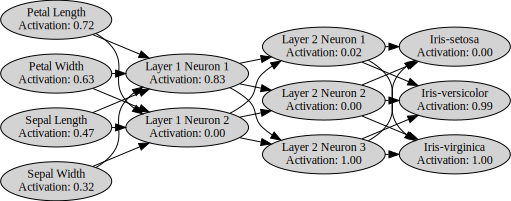

In [4]:
example_num = 10
example = X_test[example_num]

weights = classifier.coefs_
biases = classifier.intercepts_

activations = forward_pass(example, weights, biases, logistic)

dot = Digraph()
dot.attr(rankdir="LR")
dot.attr(overlap="false")  # avoid node overlaps
dot.attr(splines="true")  # use curved edges
dot.attr(margin="0")  # reduce page margin
dot.attr(pad="0")  # padding around graph
dot.attr(nodesep="0.2")
dot.attr(ranksep="0.2")

dot.attr(
    "node",
    fontsize="12",
    width="0",
    height="0",
    margin="0.01,0.01",  # very tight node margins
    style="filled",
    fillcolor="lightgrey",
)

input_features = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"]
for i, feature in enumerate(input_features):
    dot.node(f"input_{i}", label=f"{input_features[i]}\nActivation: {activations[0][i]:.2f}")

output_names = list(label_encoder.classes_)

for i, output in enumerate(output_names):
    dot.node(f"output_{i}", label=f"{output}\nActivation: {activations[-1][i]:.2f}")

# Add hidden neurons and edges between layers
layer_sizes = [len(input_features)] + list(classifier.hidden_layer_sizes) + [len(output_names)]

# Add hidden layer neurons
for layer_idx in range(1, len(layer_sizes) - 1):
    for neuron_idx in range(layer_sizes[layer_idx]):
        dot.node(f"hidden_{layer_idx}_{neuron_idx}", label=f"Layer {layer_idx} Neuron {neuron_idx+1}\nActivation: {activations[layer_idx][neuron_idx]:.2f}")

# Add edges from input to first hidden layer
for i in range(layer_sizes[0]):
    for j in range(layer_sizes[1]):
        dot.edge(f"input_{i}", f"hidden_1_{j}")

# Add edges between hidden layers (if more than one hidden layer)
for layer_idx in range(1, len(layer_sizes) - 2):
    for i in range(layer_sizes[layer_idx]):
        for j in range(layer_sizes[layer_idx + 1]):
            dot.edge(f"hidden_{layer_idx}_{i}", f"hidden_{layer_idx+1}_{j}")

# Add edges from last hidden layer to output
for i in range(layer_sizes[-2]):
    for j in range(layer_sizes[-1]):
        dot.edge(f"hidden_{len(layer_sizes)-2}_{i}", f"output_{j}")

dot.render("Report Figures/original_mlp_architecture", cleanup=True)
dot

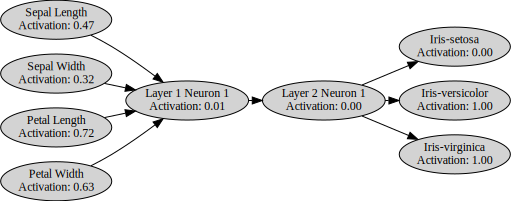

In [5]:
example_row = np.append(X_test[example_num], y_test[example_num])  
train_set = np.append(X_train, y_train.reshape(-1, 1), axis=1)

sp = LocalSpArX(
    weights,
    biases,
    "logistic",
    50,
    example_row,
    train_set,
    np.sqrt(len(X_test)) * 0.75,
    input_features,
    output_names,
)

sp_weights, sp_biases = sp.get_sparsified_mlp()

activations = forward_pass(example, sp_weights, sp_biases, logistic)

dot = Digraph()
dot.attr(rankdir="LR")
dot.attr(overlap="false")  # avoid node overlaps
dot.attr(splines="true")  # use curved edges
dot.attr(margin="0")  # reduce page margin
dot.attr(pad="0")  # padding around graph
dot.attr(nodesep="0.2")
dot.attr(ranksep="0.2")

dot.attr(
    "node",
    fontsize="12",
    width="0",
    height="0",
    margin="0.01,0.01",  # very tight node margins
    style="filled",
    fillcolor="lightgrey",
)

input_features = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"]
for i, feature in enumerate(input_features):
    dot.node(f"input_{i}", label=f"{input_features[i]}\nActivation: {activations[0][i]:.2f}")

output_names = list(label_encoder.classes_)

for i, output in enumerate(output_names):
    dot.node(f"output_{i}", label=f"{output}\nActivation: {activations[-1][i]:.2f}")

# Add hidden neurons and edges between layers
layer_sizes = sp.get_sparsified_shape()

# Add hidden layer neurons
for layer_idx in range(1, len(layer_sizes) - 1):
    for neuron_idx in range(layer_sizes[layer_idx]):
        dot.node(f"hidden_{layer_idx}_{neuron_idx}", label=f"Layer {layer_idx} Neuron {neuron_idx+1}\nActivation: {activations[layer_idx][neuron_idx]:.2f}")

# Add edges from input to first hidden layer
for i in range(layer_sizes[0]):
    for j in range(layer_sizes[1]):
        dot.edge(f"input_{i}", f"hidden_1_{j}")

# Add edges between hidden layers (if more than one hidden layer)
for layer_idx in range(1, len(layer_sizes) - 2):
    for i in range(layer_sizes[layer_idx]):
        for j in range(layer_sizes[layer_idx + 1]):
            dot.edge(f"hidden_{layer_idx}_{i}", f"hidden_{layer_idx+1}_{j}")

# Add edges from last hidden layer to output
for i in range(layer_sizes[-2]):
    for j in range(layer_sizes[-1]):
        dot.edge(f"hidden_{len(layer_sizes)-2}_{i}", f"output_{j}")

dot.render("Report Figures/sparse_mlp_architecture", cleanup=True)
dot

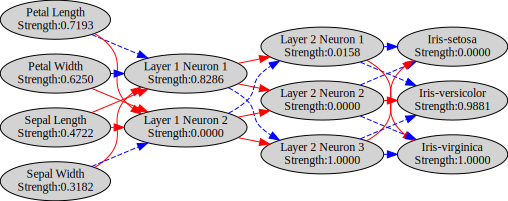

In [6]:

neurons_per_layer = [classifier.n_features_in_,
                     *list(classifier.hidden_layer_sizes),
                     classifier.n_outputs_]


converter = MLPToQBAF(neurons_per_layer,
                      classifier.coefs_,
                      classifier.intercepts_,
                      "logistic",
                      input_features,
                      output_names,
                      example)

qbaf = converter.get_qbaf()

plot = plot_qbaf(qbaf, edge_weights=False)

plot.render("Report Figures/original_qbaf", cleanup=True)
plot


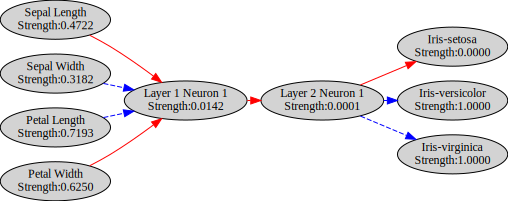

In [7]:
sp_neurons_per_layer = sp.get_sparsified_shape()
sp_converter = MLPToQBAF(sp_neurons_per_layer,
                         sp_weights,
                         sp_biases,
                         "logistic",
                         input_features,
                         output_names,
                         example)
sp_qbaf = sp_converter.get_qbaf()

plot = plot_qbaf(sp_qbaf, edge_weights=False)
plot.render("Report Figures/sparse_qbaf", cleanup=True)
plot

Computing removal scores: 100%|██████████| 11/11 [00:00<00:00, 20782.59it/s]


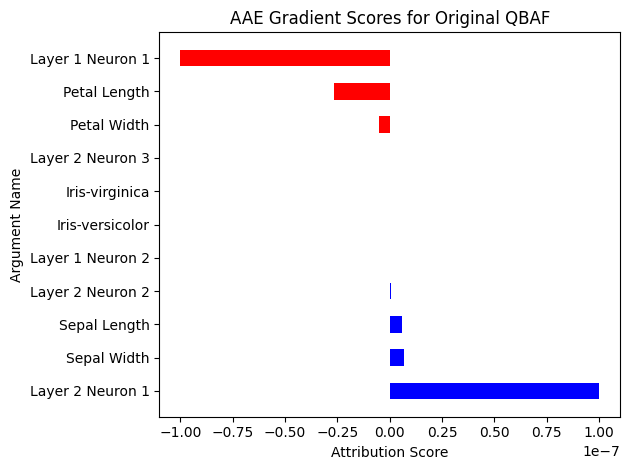

In [8]:
import matplotlib.pyplot as plt

aae = AAE(
    qbaf,
    grad.SumAggregation(),
    grad.MLPBasedInfluence(),
    output_names[0],
    1e-10
)

scores = dict(sorted(aae.get_gradients().items(), key=lambda x: x[1], reverse=True))

for name, score in scores.items():
    col = "red" if score < 0 else "blue"
    plt.barh(name, np.clip(score, -1e-7, 1e-7), color=col, height=0.5)

plt.xlabel("Attribution Score")
plt.ylabel("Argument Name")
plt.title("AAE Gradient Scores for Original QBAF")
plt.tight_layout()

In [9]:
rae = RAE(
    qbaf,
    grad.SumAggregation(),
    grad.MLPBasedInfluence(),
    output_names[0],
)

Computing SHAP scores:   0%|          | 0/23 [00:00<?, ?it/s]

Computing removal scores: 100%|██████████| 23/23 [00:00<00:00, 19563.78it/s]


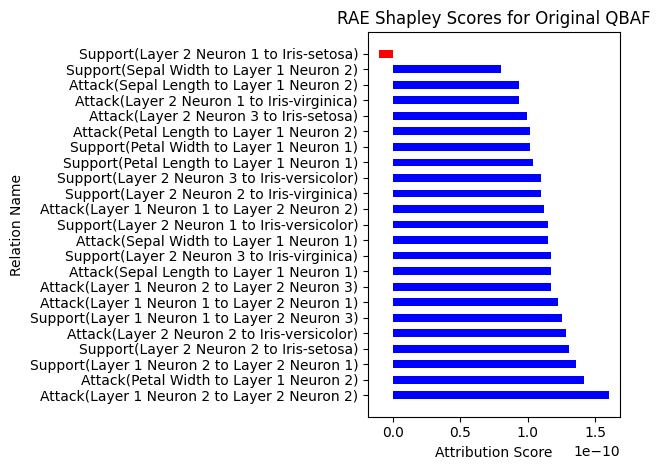

In [10]:
scores = dict(sorted(rae.get_shap_scores().items(), key=lambda x: x[1], reverse=True))

for name, score in scores.items():
    col = "red" if score < 0 else "blue"
    plt.barh(name, score-1e-11, color=col, height=0.5)

plt.xlabel("Attribution Score")
plt.ylabel("Relation Name")
plt.title("RAE Shapley Scores for Original QBAF")
plt.tight_layout()

In [11]:
ce = CounterfactualContestabilityExplanation(
    qbaf,
    grad.SumAggregation(),
    grad.MLPBasedInfluence(),
    output_names[0],
    2025,
)

ce_scores = ce.get_ce_explanation()

In [12]:
original_weights = {}

for arg_name in qbaf.arguments:
    
    arg = qbaf.arguments[arg_name]
    for attacker in arg.attackers:
        original_weights[(attacker.name, arg_name)] = arg.attackers[attacker]
    for supporter in arg.supporters:
        original_weights[(supporter.name, arg_name)] = arg.supporters[supporter]

original_weights = dict(sorted(original_weights.items(), key=lambda x: x[0], reverse=True))

for name, score in original_weights.items():
    original_weights[name] = round(score, 2)

original_weights

{('Sepal Width', 'Layer 1 Neuron 2'): np.float64(6.96),
 ('Sepal Width', 'Layer 1 Neuron 1'): np.float64(4.58),
 ('Sepal Length', 'Layer 1 Neuron 2'): np.float64(6.33),
 ('Sepal Length', 'Layer 1 Neuron 1'): np.float64(4.1),
 ('Petal Width', 'Layer 1 Neuron 2'): np.float64(12.3),
 ('Petal Width', 'Layer 1 Neuron 1'): np.float64(3.44),
 ('Petal Length', 'Layer 1 Neuron 2'): np.float64(12.63),
 ('Petal Length', 'Layer 1 Neuron 1'): np.float64(18.06),
 ('Layer 2 Neuron 3', 'Iris-virginica'): np.float64(11.91),
 ('Layer 2 Neuron 3', 'Iris-versicolor'): np.float64(4.28),
 ('Layer 2 Neuron 3', 'Iris-setosa'): np.float64(15.59),
 ('Layer 2 Neuron 2', 'Iris-virginica'): np.float64(0.32),
 ('Layer 2 Neuron 2', 'Iris-versicolor'): np.float64(1.86),
 ('Layer 2 Neuron 2', 'Iris-setosa'): np.float64(1.53),
 ('Layer 2 Neuron 1', 'Iris-virginica'): np.float64(22.44),
 ('Layer 2 Neuron 1', 'Iris-versicolor'): np.float64(4.23),
 ('Layer 2 Neuron 1', 'Iris-setosa'): np.float64(17.8),
 ('Layer 1 Neuron 2

In [13]:
ce_scores = dict(sorted(ce_scores.items(), key=lambda x: x[0], reverse=True))

for name, score in ce_scores.items():
    ce_scores[name] = round(score, 2)

ce_scores

{('Sepal Width', 'Layer 1 Neuron 2'): 0.0,
 ('Sepal Width', 'Layer 1 Neuron 1'): 0.17,
 ('Sepal Length', 'Layer 1 Neuron 2'): 0.97,
 ('Sepal Length', 'Layer 1 Neuron 1'): 0.48,
 ('Petal Width', 'Layer 1 Neuron 2'): 0.07,
 ('Petal Width', 'Layer 1 Neuron 1'): 0.65,
 ('Petal Length', 'Layer 1 Neuron 2'): 0.57,
 ('Petal Length', 'Layer 1 Neuron 1'): 0.56,
 ('Layer 2 Neuron 3', 'Iris-virginica'): 0.94,
 ('Layer 2 Neuron 3', 'Iris-versicolor'): 0.19,
 ('Layer 2 Neuron 3', 'Iris-setosa'): 0.62,
 ('Layer 2 Neuron 2', 'Iris-virginica'): 0.98,
 ('Layer 2 Neuron 2', 'Iris-versicolor'): 0.71,
 ('Layer 2 Neuron 2', 'Iris-setosa'): 0.51,
 ('Layer 2 Neuron 1', 'Iris-virginica'): 0.64,
 ('Layer 2 Neuron 1', 'Iris-versicolor'): 0.19,
 ('Layer 2 Neuron 1', 'Iris-setosa'): 0.2,
 ('Layer 1 Neuron 2', 'Layer 2 Neuron 3'): 0.05,
 ('Layer 1 Neuron 2', 'Layer 2 Neuron 2'): 0.98,
 ('Layer 1 Neuron 2', 'Layer 2 Neuron 1'): 0.4,
 ('Layer 1 Neuron 1', 'Layer 2 Neuron 3'): 0.1,
 ('Layer 1 Neuron 1', 'Layer 2 Neur

In [14]:
df = pd.DataFrame.from_dict(original_weights, orient='index', columns=['Original Weight']).reset_index().rename(columns={'index': 'Argument Pair'})
df['CE Score'] = df['Argument Pair'].map(ce_scores)
df.head(10).to_latex("small_cf.tex", index=False, float_format="%.2f")